##  Imports

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap


## Load and preprocessing MNIST

In [ ]:
(trainX, trainY), _ = mnist.load_data()
trainX = trainX.astype("float32") / 255.0

def preprocess_images_batch(images, batch_size=500):
    resized = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        batch = tf.expand_dims(batch, -1)           # (28,28) -> (28,28,1)
        batch = tf.image.resize(batch, (224, 224)) # resize to 224x224
        batch = tf.image.grayscale_to_rgb(batch)   # (224,224,1) -> (224,224,3)
        resized.append(batch)
    return tf.concat(resized, axis=0).numpy()

x_subset = preprocess_images_batch(trainX[:2000])
y_subset = trainY[:2000]
y_subset_cat = to_categorical(y_subset, num_classes=10)


## Load MobileNetV2 pretrained (feature extraction BEFORE fine-tuning)

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
base_model.trainable = False

feature_extractor_before = Model(inputs=base_model.input, outputs=base_model.output)
features_before = feature_extractor_before.predict(x_subset, batch_size=64, verbose=1)


32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step


## Fine Tuning

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.Dense(128, activation='relu', name="features")(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune on subset
x_train_small = preprocess_images_batch(trainX[:5000])
y_train_small = to_categorical(trainY[:5000], num_classes=10)

model.fit(x_train_small, y_train_small, epochs=10, batch_size=64, validation_split=0.1)


Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 26s 234ms/step - accuracy: 0.6732 - loss: 1.0815 - val_accuracy: 0.9180 - val_loss: 0.2978
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 25s 68ms/step - accuracy: 0.9510 - loss: 0.1765 - val_accuracy: 0.9540 - val_loss: 0.1901
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9713 - loss: 0.1131 - val_accuracy: 0.9320 - val_loss: 0.1997
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.9791 - loss: 0.0835 - val_accuracy: 0.9640 - val_loss: 0.1740
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9850 - loss: 0.0615 - val_accuracy: 0.9580 - val_loss: 0.1623
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9895 - loss: 0.0470 - val_accuracy: 0.9540 - val_loss: 0.1722
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.9935 - loss: 0.0307 - val_accuracy: 0.9540 - val_loss: 0.1501
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9935 - loss: 0.0296 - val_accuracy: 0.9600 

## Extract features AFTER fine-tuning from intermediate Dense(128) layer

In [ ]:
feature_extractor_after = Model(inputs=model.input, outputs=model.get_layer("features").output)
features_after = feature_extractor_after.predict(x_subset, batch_size=64, verbose=1)


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step


## Visualization and plots(PCA, t-SNE, UMAP)

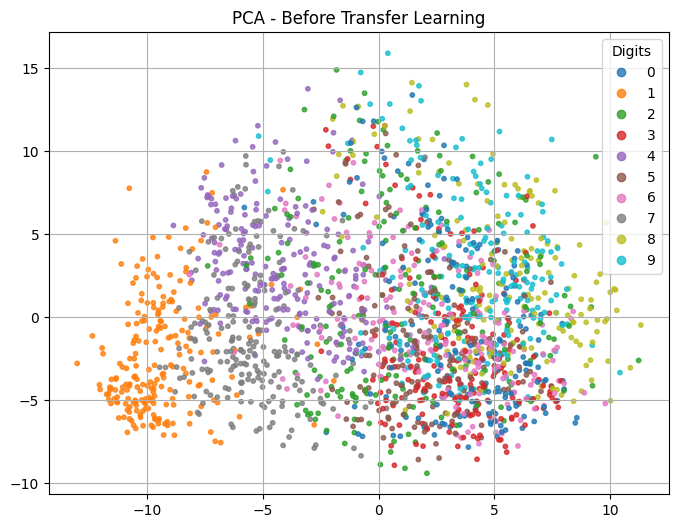

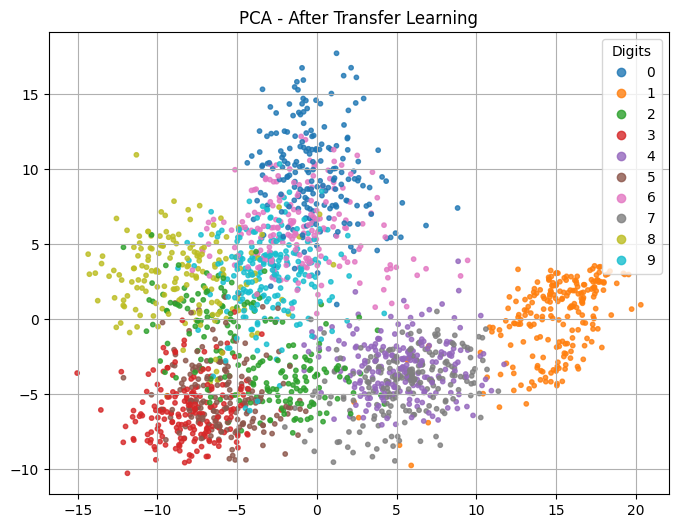

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


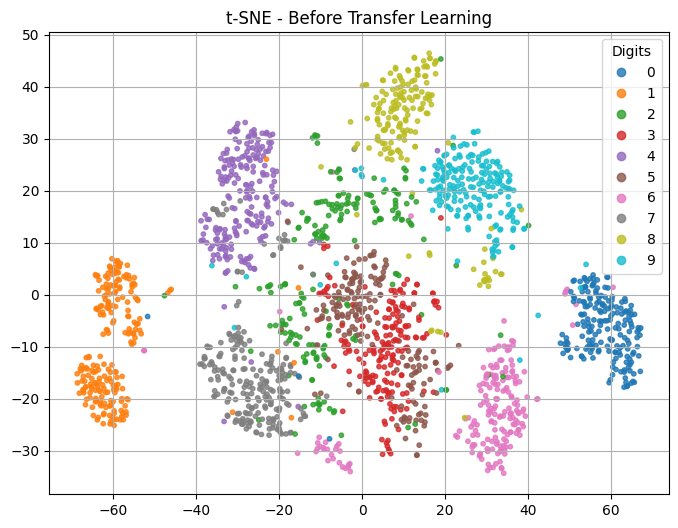

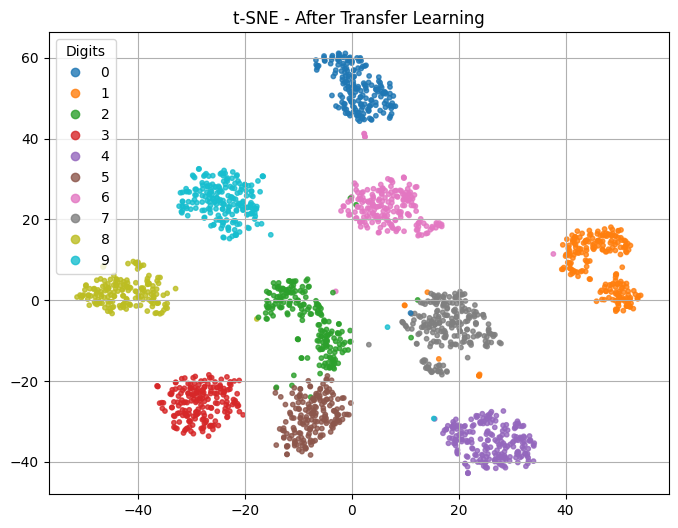

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


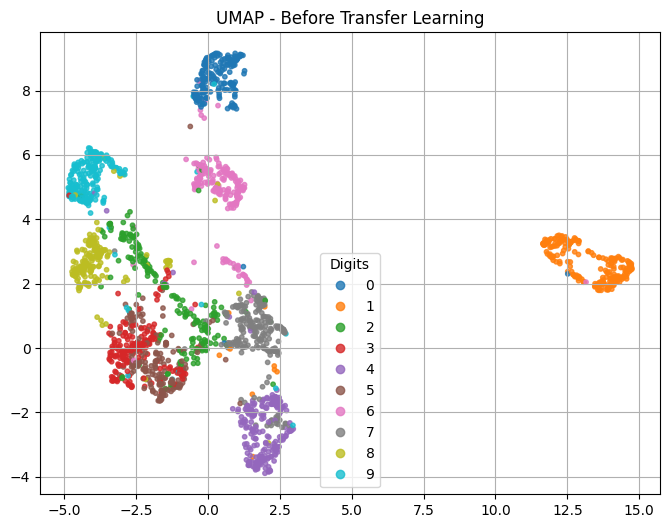

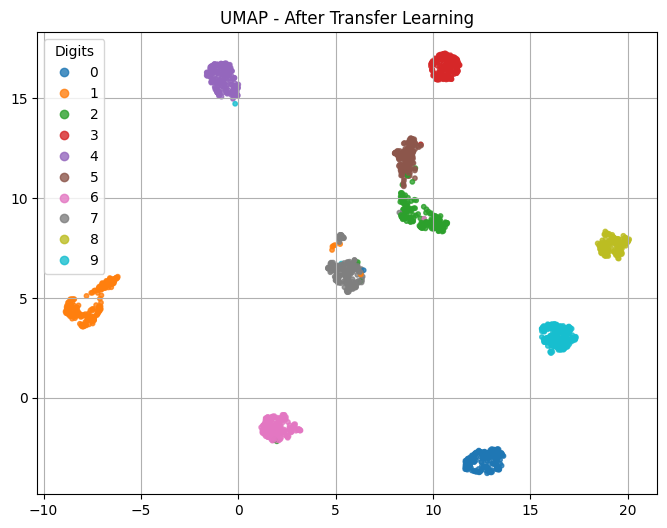

In [ ]:
def plot_2d(X, y, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=10, alpha=0.8)
    plt.legend(*scatter.legend_elements(), title="Digits", loc='best')
    plt.title(title)
    plt.grid(True)
    plt.show()

# PCA
pca = PCA(n_components=2)
pca_before = pca.fit_transform(features_before)
pca_after = pca.fit_transform(features_after)
plot_2d(pca_before, y_subset, "PCA - Before Transfer Learning")
plot_2d(pca_after, y_subset, "PCA - After Transfer Learning")

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
tsne_before = tsne.fit_transform(features_before)
tsne_after = tsne.fit_transform(features_after)
plot_2d(tsne_before, y_subset, "t-SNE - Before Transfer Learning")
plot_2d(tsne_after, y_subset, "t-SNE - After Transfer Learning")

# UMAP
umap_model = umap.UMAP(n_components=2)
umap_before = umap_model.fit_transform(features_before)
umap_after = umap_model.fit_transform(features_after)
plot_2d(umap_before, y_subset, "UMAP - Before Transfer Learning")
plot_2d(umap_after, y_subset, "UMAP - After Transfer Learning")


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

def plot_all_reductions(features_before, features_after, y_subset):
    # Initialize models
    pca = PCA(n_components=2)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    umap_model = umap.UMAP(n_components=2, random_state=42)

    # Perform dimensionality reductions
    pca_before = pca.fit_transform(features_before)
    pca_after = pca.fit_transform(features_after)

    tsne_before = tsne.fit_transform(features_before)
    tsne_after = tsne.fit_transform(features_after)

    umap_before = umap_model.fit_transform(features_before)
    umap_after = umap_model.fit_transform(features_after)

    # Set up 2x3 subplots
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    titles = ['PCA Before', 'TSNE Before', 'UMAP Before',
              'PCA After', 'TSNE After', 'UMAP After']
    data = [(pca_before, y_subset), (tsne_before, y_subset), (umap_before, y_subset),
            (pca_after, y_subset), (tsne_after, y_subset), (umap_after, y_subset)]

    # Plot each subplot
    for i, ax in enumerate(axs.flat):
        X, y = data[i]
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=10, alpha=0.8)
        ax.set_title(titles[i])
        ax.grid(True)

        # Add color bar only once per column
        if i % 3 == 0:
            cbar = fig.colorbar(scatter, ax=ax)
            cbar.set_label('Digit Class')

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


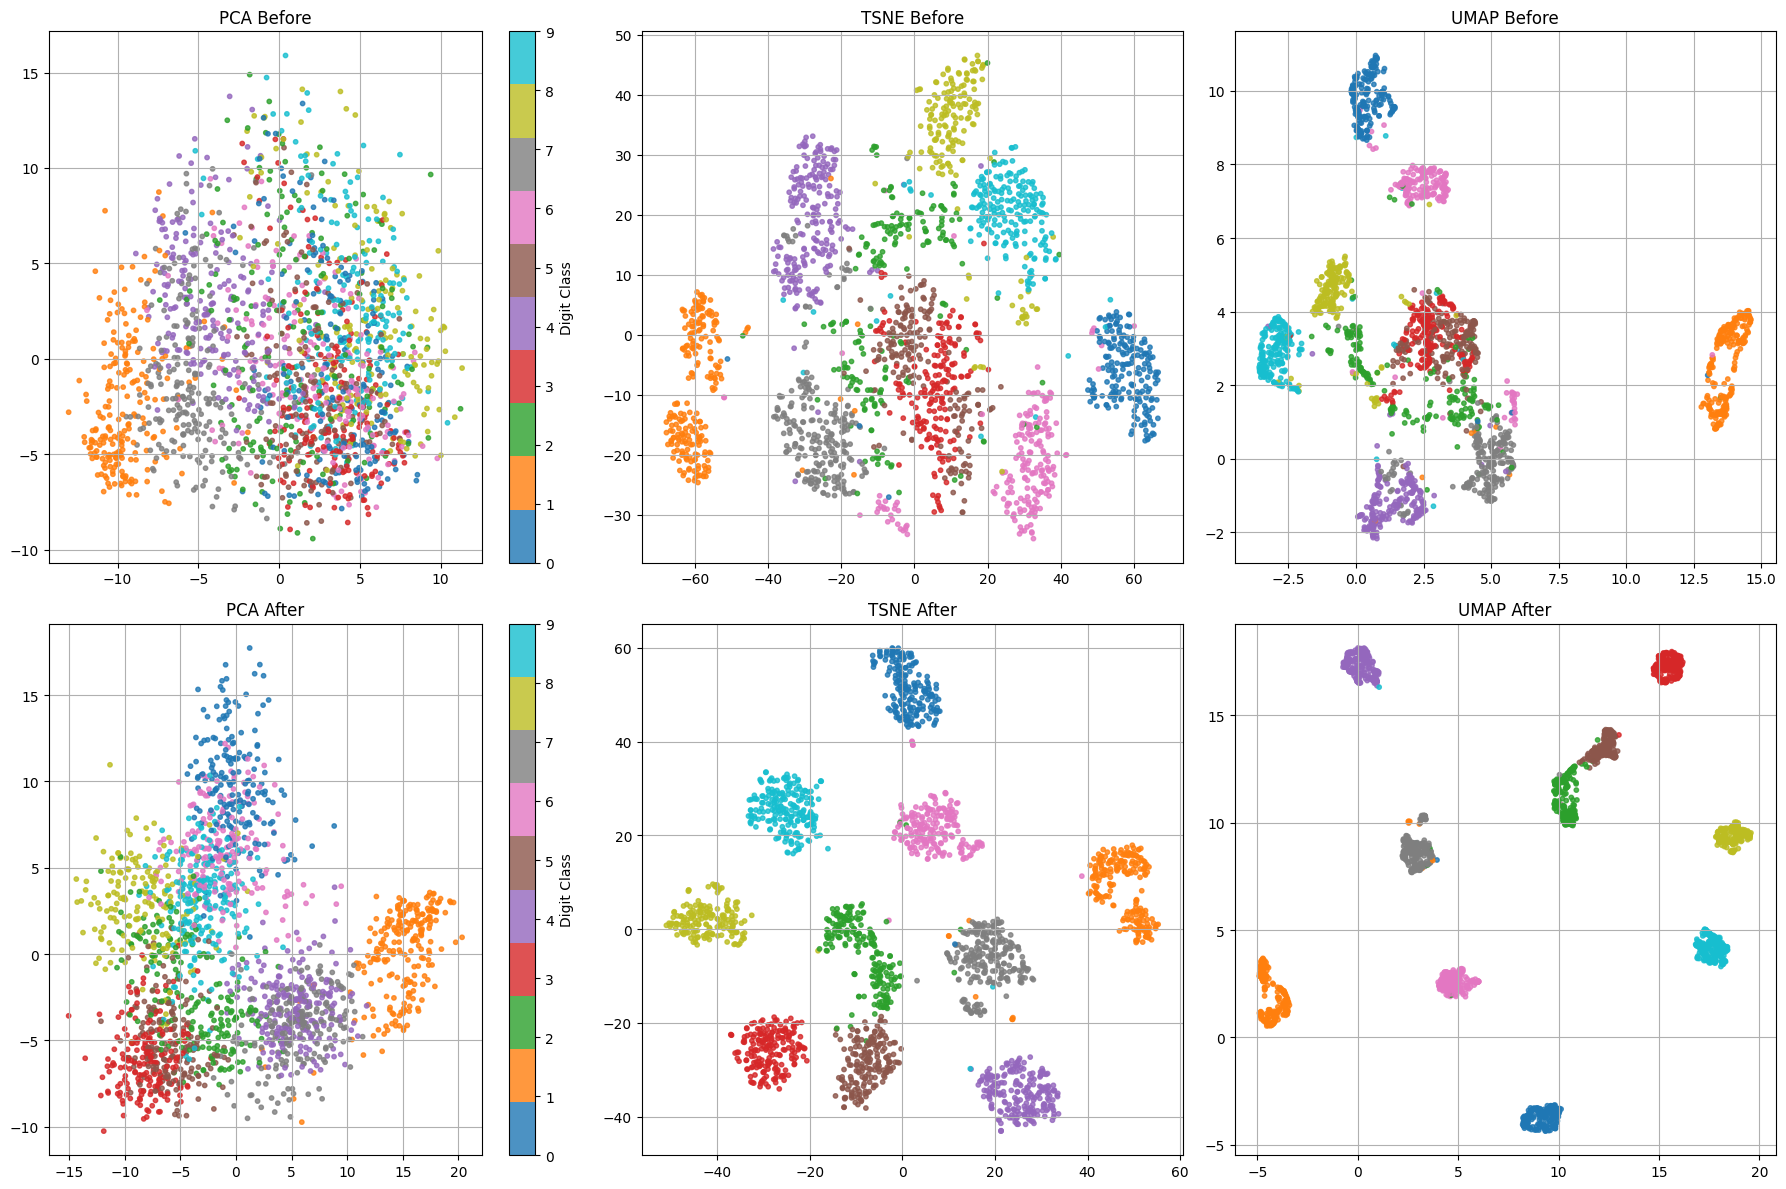

In [ ]:
plot_all_reductions(features_before, features_after, y_subset)
